In [13]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

## Data preparation
* getting information,shape of data
* dropping unrequired columns
* looking at labels unique values

In [15]:
df = pd.read_csv("Stress.csv")
df.head()

,subreddit,post_id,sentence_range,text,label,confidence,social_timestamp
0,ptsd,8601tu,"(15, 20)","He said he had not felt that way before, sugge...",1,0.8,1521614353
1,assistance,8lbrx9,"(0, 5)","Hey there r/assistance, Not sure if this is th...",0,1.0,1527009817
2,ptsd,9ch1zh,"(15, 20)",My mom then hit me with the newspaper and it s...,1,0.8,1535935605
3,relationships,7rorpp,"[5, 10]","until i met my new boyfriend, he is amazing, h...",1,0.6,1516429555
4,survivorsofabuse,9p2gbc,"[0, 5]",October is Domestic Violence Awareness Month a...,1,0.8,1539809005


In [16]:
df.shape,df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2838 entries, 0 to 2837
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   subreddit         2838 non-null   object 
 1   post_id           2838 non-null   object 
 2   sentence_range    2838 non-null   object 
 3   text              2838 non-null   object 
 4   label             2838 non-null   int64  
 5   confidence        2838 non-null   float64
 6   social_timestamp  2838 non-null   int64  
dtypes: float64(1), int64(2), object(4)
memory usage: 155.3+ KB


((2838, 7), None)

In [17]:
not_used_cols = ['subreddit','post_id','sentence_range','confidence','social_timestamp']
df1 = df.drop(not_used_cols,axis=1)
df1.sample(3)

,text,label
542,When it is his weekend off). He grumbles and y...,1
1678,I have been thinking about it and I think that...,1
1701,I currently have $7k in my bank account. I hav...,0


In [18]:
df1['label'].unique()

array([1, 0])

## Text processing
* importing required libraries (nltk,spacy,urllib,re etc.)
* downloading required database (omw), wordnet, punkt, stopwords
* cleaning data (with regualr expression)

In [19]:
import nltk
import re
from urllib.parse import urlparse
from spacy import load
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

In [20]:
nltk.download('omw-1.4') # Open Multilingual Wordnet, this is an lexical database 
nltk.download('wordnet') 
nltk.download('wordnet2022')
nltk.download('punkt')
nltk.download('stopwords')
! cp -rf /usr/share/nltk_data/corpora/wordnet2022 /usr/share/nltk_data/corpora/wordnet

[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package wordnet2022 to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet2022.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


cp: cannot stat '/usr/share/nltk_data/corpora/wordnet2022': No such file or directory


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [21]:
lemmatizer = WordNetLemmatizer()
stop_words = list(stopwords.words('english'))
print(stop_words)

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

### Regular expressions for cleaning text data

In [22]:
def textPocess(sent):
    try:
        # brackets replacing by space
        sent = re.sub('[][)(]',' ',sent)

        # url removing
        sent = [word for word in sent.split() if not urlparse(word).scheme]
        sent = ' '.join(sent)

        # removing escap characters
        sent = re.sub(r'\@\w+','',sent)

        # removing html tags 
        sent = re.sub(re.compile("<.*?>"),'',sent)

        # getting only characters and numbers from text
        sent = re.sub("[^A-Za-z0-9]",' ',sent)

        # lower case all words
        sent = sent.lower()
        
        # strip all words from sentences
        sent = [word.strip() for word in sent.split()]
        sent = ' '.join(sent)

        # word tokenization
        tokens = word_tokenize(sent)
        
        # removing words which are in stopwords
        for word in tokens:
            if word in stop_words:
                tokens.remove(word)
        
        # lemmatization
        sent = [lemmatizer.lemmatize(word) for word in tokens]
        sent = ' '.join(sent)
        return sent
    
    except Exception as ex:
        print(sent,"\n")
        print("Error ",ex)
    

In [23]:
df1['processed_text'] = df1['text'].apply(lambda text: textPocess(text))
df1.head()

,text,label,processed_text
0,"He said he had not felt that way before, sugge...",1,said had felt way suggeted go rest so trigger ...
1,"Hey there r/assistance, Not sure if this is th...",0,hey r assistance sure right place post but go ...
2,My mom then hit me with the newspaper and it s...,1,mom hit newspaper shocked that would this know...
3,"until i met my new boyfriend, he is amazing, h...",1,met new boyfriend amazing kind sweet is good s...
4,October is Domestic Violence Awareness Month a...,1,october domestic violence awareness month dome...


In [24]:
print("without process ----> ",df1['text'].iloc[0],end='\n\n')
print("after process ----> ",df1['processed_text'].iloc[0])

without process ---->  He said he had not felt that way before, suggeted I go rest and so ..TRIGGER AHEAD IF YOUI'RE A HYPOCONDRIAC LIKE ME: i decide to look up "feelings of doom" in hopes of maybe getting sucked into some rabbit hole of ludicrous conspiracy, a stupid "are you psychic" test or new age b.s., something I could even laugh at down the road. No, I ended up reading that this sense of doom can be indicative of various health ailments; one of which I am prone to.. So on top of my "doom" to my gloom..I am now f'n worried about my heart. I do happen to have a physical in 48 hours.

after process ---->  said had felt way suggeted go rest so trigger ahead youi hypocondriac like decide look feeling doom hope maybe getting sucked some rabbit hole ludicrous conspiracy stupid you psychic test new age b something could even laugh down road ended reading this sense doom be indicative various health ailment one which am prone so top my doom my gloom am f n worried my heart i do happen ha

## Vectorization / Word embedding
* BOW (Bag Of Words) / TF-IDF vectorizer
* converting it into dataframes

### --> BOW (Bag Of Word) / count vectorizer

In [25]:
from sklearn.feature_extraction.text import CountVectorizer
MIN_DF = 1 
# min_df is used for removing terms that appear too infrequently. 
# For example: min_df = 0.01 means "ignore terms that appear in less than 1% of the documents". 

In [26]:
cv = CountVectorizer(min_df=MIN_DF)
cv_df = cv.fit_transform(df1['processed_text'])
cv_df.toarray()

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [27]:
cv_df = pd.DataFrame(cv_df.toarray(),columns=cv.get_feature_names_out())
cv_df.head(3)

,00,000,02,06,10,100,1000,100kg,100mg,100x,...,zines,zinsser,zip,zofran,zoloft,zombie,zone,zoo,zuko,zumba
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### --> TF-IDF (Term frequency - inverse document frequency)

In [28]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [29]:
tf = TfidfVectorizer(min_df=MIN_DF)
tf_df = tf.fit_transform(df1['processed_text'])
tf_df.toarray()

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [30]:
tf_df = pd.DataFrame(tf_df.toarray(),columns=tf.get_feature_names_out())
tf_df.head(3)

,00,000,02,06,10,100,1000,100kg,100mg,100x,...,zines,zinsser,zip,zofran,zoloft,zombie,zone,zoo,zuko,zumba
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [31]:
tf_df.describe()

,00,000,02,06,10,100,1000,100kg,100mg,100x,...,zines,zinsser,zip,zofran,zoloft,zombie,zone,zoo,zuko,zumba
count,2838.000000,2838.000000,2838.000000,2838.000000,2838.000000,2838.000000,2838.000000,2838.000000,2838.000000,2838.000000,...,2838.000000,2838.000000,2838.000000,2838.000000,2838.000000,2838.000000,2838.000000,2838.000000,2838.000000,2838.000000
mean,0.000162,0.000548,0.000109,0.000069,0.003244,0.001784,0.000576,0.000106,0.000115,0.000067,...,0.000078,0.000072,0.000204,0.000078,0.000715,0.000126,0.000245,0.000089,0.000054,0.000040
std,0.006128,0.009998,0.005801,0.003671,0.020994,0.017215,0.011156,0.005624,0.004534,0.003573,...,0.004144,0.003841,0.007786,0.004157,0.011797,0.004733,0.006851,0.004754,0.002873,0.002105
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,0.252083,0.327600,0.309059,0.195549,0.260810,0.267280,0.310333,0.299611,0.215015,0.190366,...,0.220738,0.204637,0.336073,0.221471,0.306537,0.183347,0.268149,0.253283,0.153067,0.112129


In [32]:
cv_df.shape,tf_df.shape

((2838, 10267), (2838, 10267))

## Model Building
* with BOW (Logistic Regression, MultonomialNB, RandomForestClassifier)
* with TF-IDF (Logistic Regression, MultonomialNB, RandomForestClassifier)


In [33]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
import warnings
warnings.filterwarnings('ignore')

###  --> For BOW

In [34]:
X_train,X_test,y_train,y_test = train_test_split(cv_df,df1['label'],stratify=df1['label'])
X_train.shape,y_test.shape

((2128, 10267), (710,))

#### --------> Logistic Regression

In [35]:
model_lr = LogisticRegression().fit(X_train,y_train)
model_lr.score(X_train,y_train),model_lr.score(X_test,y_test)

(0.9981203007518797, 0.7380281690140845)

#### --------> Naive Bayes

In [36]:
model_nb = MultinomialNB().fit(X_train,y_train)
model_nb.score(X_train,y_train),model_nb.score(X_test,y_test)

(0.9205827067669173, 0.7309859154929578)

#### --------> Random Forest 

In [37]:
model_rf = RandomForestClassifier().fit(X_train,y_train)
model_rf.score(X_train,y_train),model_rf.score(X_test,y_test)

(0.9990601503759399, 0.7112676056338029)

### --> For TF-IDF

In [38]:
X_train1,X_test1,y_train1,y_test1 = train_test_split(tf_df,df1['label'],stratify=df1['label'])
X_train1.shape,y_test1.shape

((2128, 10267), (710,))

#### --------> Logistic Regression

In [39]:
model_lr = LogisticRegression().fit(X_train1,y_train1)
model_lr.score(X_train1,y_train1),model_lr.score(X_test1,y_test1)

(0.9055451127819549, 0.7676056338028169)

#### --------> Naive Bayes

In [40]:
model_nb = MultinomialNB().fit(X_train1,y_train1)
model_nb.score(X_train1,y_train1),model_nb.score(X_test1,y_test1)

(0.8228383458646616, 0.7028169014084507)

#### --------> Random Forest 

In [41]:
model_rf = RandomForestClassifier().fit(X_train1,y_train1)
model_rf.score(X_train1,y_train1),model_rf.score(X_test1,y_test1)

(0.9981203007518797, 0.7253521126760564)

### "Breaking news, folks! In a stunning turn of events, the underdogs Logistic Regression and Naive Bayes have pulled off an epic upset and knocked out the reigning champion Random Forest in the battle of the algorithms! Who knew that old-school techniques still had some moves left in them? It just goes to show that in the world of data science, anything is possible!" 😂😂😂😂😂😂😂😂

## Validation / calibration
* confusion matrix 
* classification report

In [42]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix,classification_report

In [43]:
y_pred = model_lr.predict(X_test1)
cm = confusion_matrix(y_pred,y_test1)
cm

array([[250,  77],
       [ 88, 295]])

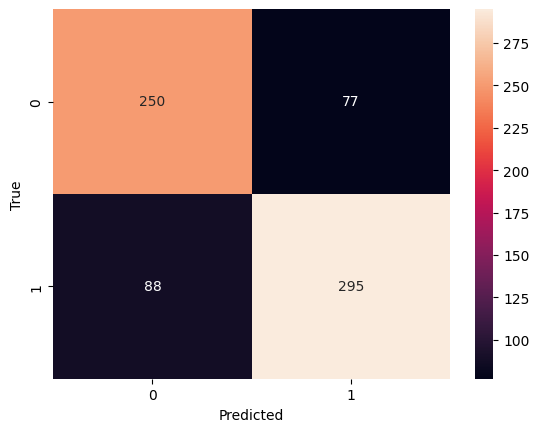

In [44]:
sns.heatmap(cm,annot=True,fmt='')
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

In [45]:
print(classification_report(y_pred,y_test1))

              precision    recall  f1-score   support

           0       0.74      0.76      0.75       327
           1       0.79      0.77      0.78       383

    accuracy                           0.77       710
   macro avg       0.77      0.77      0.77       710
weighted avg       0.77      0.77      0.77       710



## Generating predictions (Exciting part of notebook) 🤔

In [46]:
model = LogisticRegression().fit(tf_df,df1['label'])
model.score(tf_df,df1['label'])

0.8999295278365046

In [52]:
def predictor(text):
    # processed = textPocess(text)
    embedded_words = tf.transform([text])
    res = model.predict(embedded_words)
    if res[0] == 1:
        res = "this person is in stress"
    else:
        res = "this person is not in stress"
    return res

In [48]:
import pickle
pickle.dump(predictor,open('stress_detector.pkl', 'wb'))

In [53]:
text1 = """This is the worst thing that happened to me today. I got less marks in my exam, 
            so it is not going to help me in my future."""
text2 = """Hi Shashank sir, I gained a lot of knowledge from you for my future use. 
            This was a very fun journey for me. Thanks for boosting my confidence."""

text3 = """
User: Hi, I need help!

Chatbot: Of course, what can I assist you with?

User: I have a deadline tomorrow and I haven't even started on my project yet. I'm freaking out!

Chatbot: Okay, take a deep breath. Let's start by breaking down the project into smaller tasks. 
What do you need to do first?

User: I need to gather some research and data, but I don't even know where to start!

Chatbot: No problem. Let's begin by outlining the main points of your project, 

and then we can find the resources you need to complete each section. Can you tell me more about your project?

User: It's a marketing report for my boss. I need to analyze our competitors and come up with a new marketing strategy.

Chatbot: Great, that gives us a good starting point. 

Let's look for industry reports and market research that can give you insights into your competitors. 

And don't forget to take breaks and pace yourself as you work on each section. You got this!"""

text4 = """
User: Hi there! How are you doing today?

Chatbot: Hello! I'm doing well, thanks for asking. How about you?

User: I'm doing pretty well too, thanks. I just wanted to ask you a question about your service.

Chatbot: Of course, I'm here to help. What can I assist you with?

User: I'm interested in learning more about your pricing options. Can you provide me with some information?

Chatbot: Absolutely! We have several different pricing plans depending on your needs. 

Would you like me to send you a link to our pricing page?

User: Yes, that would be great. Also, do you offer any discounts or promotions?

Chatbot: Yes, we do offer discounts for long-term contracts and for certain types of organizations. 

Would you like me to provide more details?

User: That would be helpful, thank you.

Chatbot: Sure thing! Our team can provide you with all the information you need to make an informed decision. 

Is there anything else I can help you with today?"""

In [54]:
print(predictor(text1))
print(predictor(text2))
print(predictor(text3))
print(predictor(text4))

this person is in stress
this person is not in stress
this person is in stress
this person is not in stress


## download model

## Conclusion

* After looking at the score and predictions, we can say that our model has good prediction capability, even though there are 2838 datapoints.
* I intentionally used the Random Forest algorithm to remove the mindset of AI developers that Random Forest always gets better results.
* The reality is that the score of a model depends on the structure of its algorithm. Every algorithm has its own "USP and each algorithm is developed to solve a particular type of problem.

**And this is the intention behind why I wrote this notebook.**